# Load the Cleaned Data

In [1]:
import pandas as pd
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/TelcoCustomerChurn/TelcoChurnSQLCleaned.csv')
df.head()

,customerID,gender,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,DeviceProtection,Contract,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,5575-GNVDE,Male,34,1,0,DSL,1,1,One year,Mailed check,56.950001,1889.500000,0
1,3668-QPYBK,Male,2,1,0,DSL,1,0,Month-to-month,Mailed check,53.849998,108.150002,1
2,9237-HQITU,Female,2,1,0,Fiber optic,0,0,Month-to-month,Electronic check,70.699997,151.649994,1
3,9305-CDSKC,Female,8,1,1,Fiber optic,0,1,Month-to-month,Electronic check,99.650002,820.500000,1
4,1452-KIOVK,Male,22,1,1,Fiber optic,0,0,Month-to-month,Credit card (automatic),89.099998,1949.400024,0


In [2]:
print(df.isnull().sum())
print(df.dtypes)

customerID          0
gender              0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
DeviceProtection    0
Contract            0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64
customerID           object
gender               object
tenure                int64
PhoneService          int64
MultipleLines         int64
InternetService      object
OnlineSecurity        int64
DeviceProtection      int64
Contract             object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges        float64
Churn                 int64
dtype: object


In [3]:
df = df.drop('customerID', axis=1)

# Encoding Categorical Features

In [4]:
categorical_cols = ['gender', 'PhoneService', 'MultipleLines', 'InternetService',
                   'OnlineSecurity', 'DeviceProtection', 'Contract', 'PaymentMethod']
df_encoded = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

# Scaling Numeric Features

In [5]:
from sklearn.preprocessing import StandardScaler
numeric_cols = ['tenure', 'MonthlyCharges', 'TotalCharges']
scaler = StandardScaler()
df_encoded[numeric_cols] = scaler.fit_transform(df_encoded[numeric_cols])
print(df_encoded[numeric_cols].head())  # Verify scaled values

     tenure  MonthlyCharges  TotalCharges
0  0.038293       -1.355490     -0.419395
1 -1.260743       -1.524849     -1.156918
2 -1.260743       -0.604298     -1.138908
3 -1.017174        0.977303     -0.861988
4 -0.448846        0.400934     -0.394595


In [6]:
df_encoded['charge_per_month'] = df['TotalCharges'] / df['tenure'].replace(0, 1)
df_encoded['charge_per_month'] = scaler.fit_transform(df_encoded[['charge_per_month']])

# Spliting Features and Target

In [7]:
X = df_encoded.drop('Churn', axis=1)  # All features except target
y = df_encoded['Churn']  # Target variable (0 or 1)
print(X.columns)  # Check feature names

Index(['tenure', 'MonthlyCharges', 'TotalCharges', 'gender_Male',
       'MultipleLines_1', 'InternetService_Fiber optic', 'OnlineSecurity_1',
       'DeviceProtection_1', 'Contract_One year', 'Contract_Two year',
       'PaymentMethod_Credit card (automatic)',
       'PaymentMethod_Electronic check', 'PaymentMethod_Mailed check',
       'charge_per_month'],
      dtype='object')


In [8]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(random_state=42)
rf.fit(X, y)
feature_importance = pd.DataFrame({'feature': X.columns, 'importance': rf.feature_importances_})
print(feature_importance.sort_values('importance', ascending=False).head(10))

                           feature  importance
2                     TotalCharges    0.214249
0                           tenure    0.186135
13                charge_per_month    0.183571
1                   MonthlyCharges    0.181306
5      InternetService_Fiber optic    0.034916
6                 OnlineSecurity_1    0.032115
11  PaymentMethod_Electronic check    0.030679
9                Contract_Two year    0.028397
3                      gender_Male    0.024380
8                Contract_One year    0.022310


# Split Data into Training and Testing Sets

In [9]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(X_train.shape, X_test.shape)  # Verify split (e.g., 80% train, 20% test)

(3865, 14) (967, 14)


# Choose and Train Baseline Model

In [10]:
from sklearn.linear_model import LogisticRegression
log_reg = LogisticRegression(max_iter=1000, random_state=42)
log_reg.fit(X_train, y_train)

LogisticRegression(max_iter=1000, random_state=42)

In [11]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)

from xgboost import XGBClassifier
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb.fit(X_train, y_train)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [23:24:36] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, random_state=42, ...)

In [12]:
y_pred_log_reg = log_reg.predict(X_test)
y_pred_rf = rf.predict(X_test)
y_pred_xgb = xgb.predict(X_test)

In [13]:
from sklearn.metrics import classification_report, roc_auc_score

# Logistic Regression
print("Logistic Regression:")
print(classification_report(y_test, y_pred_log_reg))
print("AUC-ROC:", roc_auc_score(y_test, log_reg.predict_proba(X_test)[:, 1]))

# Random Forest
print("Random Forest:")
print(classification_report(y_test, y_pred_rf))
print("AUC-ROC:", roc_auc_score(y_test, rf.predict_proba(X_test)[:, 1]))

# XGBoost
print("XGBoost:")
print(classification_report(y_test, y_pred_xgb))
print("AUC-ROC:", roc_auc_score(y_test, xgb.predict_proba(X_test)[:, 1]))

Logistic Regression:
              precision    recall  f1-score   support

           0       0.81      0.83      0.82       646
           1       0.64      0.60      0.62       321

    accuracy                           0.76       967
   macro avg       0.73      0.72      0.72       967
weighted avg       0.75      0.76      0.76       967

AUC-ROC: 0.813942497805812
Random Forest:
              precision    recall  f1-score   support

           0       0.80      0.83      0.81       646
           1       0.62      0.58      0.60       321

    accuracy                           0.74       967
   macro avg       0.71      0.70      0.70       967
weighted avg       0.74      0.74      0.74       967

AUC-ROC: 0.7853312500602799
XGBoost:
              precision    recall  f1-score   support

           0       0.81      0.79      0.80       646
           1       0.59      0.62      0.61       321

    accuracy                           0.73       967
   macro avg       0.70     

# Cross-Validation for Robustness

In [14]:
from sklearn.model_selection import cross_val_score

models = {'Logistic Regression': log_reg, 'Random Forest': rf, 'XGBoost': xgb}
for name, model in models.items():
    scores = cross_val_score(model, X, y, cv=5, scoring='roc_auc')
    print(f"{name} Cross-Validated AUC-ROC: {scores.mean():.3f} (±{scores.std():.3f})")

Logistic Regression Cross-Validated AUC-ROC: 0.816 (±0.010)
Random Forest Cross-Validated AUC-ROC: 0.791 (±0.012)


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [23:27:10] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [23:27:10] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [23:27:11] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [23:27:11] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBoost Cross-Validated AUC-ROC: 0.793 (±0.011)


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [23:27:11] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


# Visualize Performance

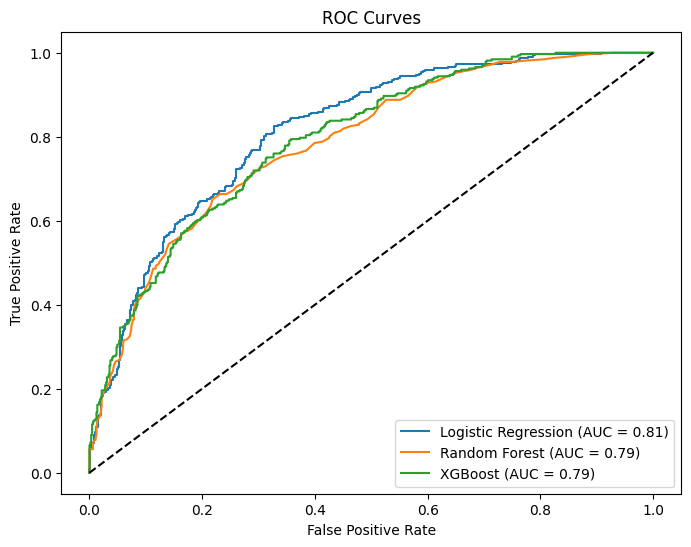

In [15]:
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
for name, model in models.items():
    fpr, tpr, _ = roc_curve(y_test, model.predict_proba(X_test)[:, 1])
    plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc_score(y_test, model.predict_proba(X_test)[:, 1]):.2f})')
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves')
plt.legend()
plt.show()

# Model Tuning and Optimization

In [16]:
from xgboost import XGBClassifier
base_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)

In [17]:
print(y_train.value_counts(normalize=True))  # e.g., 0: 0.73, 1: 0.27

Churn
0    0.672704
1    0.327296
Name: proportion, dtype: float64


In [18]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.3],
    'n_estimators': [100, 200],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

grid_search = GridSearchCV(base_model, param_grid, scoring='roc_auc', cv=5, n_jobs=-1)
grid_search.fit(X_train, y_train)

print("Best Parameters:", grid_search.best_params_)
print("Best AUC-ROC:", grid_search.best_score_)

Best Parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.8}
Best AUC-ROC: 0.8161834904226207


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [23:40:07] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


In [19]:
tuned_model = XGBClassifier(
    max_depth=grid_search.best_params_['max_depth'],
    learning_rate=grid_search.best_params_['learning_rate'],
    n_estimators=grid_search.best_params_['n_estimators'],
    subsample=grid_search.best_params_['subsample'],
    colsample_bytree=grid_search.best_params_['colsample_bytree'],
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42
)
tuned_model.fit(X_train, y_train)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [23:41:17] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=3,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=100,
              n_jobs=None, num_parallel_tree=None, random_state=42, ...)

In [23]:
from sklearn.metrics import classification_report, roc_auc_score

# Predictions and evaluation for the tuned model
y_pred_tuned = tuned_model.predict(X_test)
print("Tuned XGBoost:")
print(classification_report(y_test, y_pred_tuned))
print("AUC-ROC:", roc_auc_score(y_test, tuned_model.predict_proba(X_test)[:, 1]))


Tuned XGBoost:
              precision    recall  f1-score   support

           0       0.81      0.85      0.83       646
           1       0.66      0.60      0.62       321

    accuracy                           0.76       967
   macro avg       0.73      0.72      0.73       967
weighted avg       0.76      0.76      0.76       967

AUC-ROC: 0.8219500786049786


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [23:46:16] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


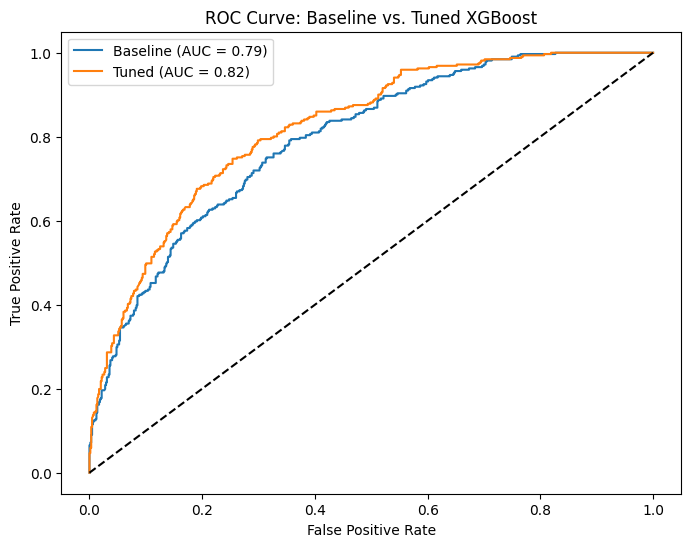

In [25]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score
from xgboost import XGBClassifier

# Assuming base_model was not fitted earlier:
base_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
base_model.fit(X_train, y_train)  # Fit the base model

plt.figure(figsize=(8, 6))
fpr_base, tpr_base, _ = roc_curve(y_test, base_model.predict_proba(X_test)[:, 1])
fpr_tuned, tpr_tuned, _ = roc_curve(y_test, tuned_model.predict_proba(X_test)[:, 1])
plt.plot(fpr_base, tpr_base, label=f'Baseline (AUC = {roc_auc_score(y_test, base_model.predict_proba(X_test)[:, 1]):.2f})')
plt.plot(fpr_tuned, tpr_tuned, label=f'Tuned (AUC = {roc_auc_score(y_test, tuned_model.predict_proba(X_test)[:, 1]):.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve: Baseline vs. Tuned XGBoost')
plt.legend()
plt.show()

# Extract Model Insights in Python

In [27]:
import pandas as pd
from xgboost import XGBClassifier

tuned_model = XGBClassifier(
    objective='binary:logistic',
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42
)
tuned_model.fit(X_train, y_train)  # Fit the tuned model

feature_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': tuned_model.feature_importances_
})
feature_importance = feature_importance.sort_values('Importance', ascending=False)
print(feature_importance.head(10))

                           Feature  Importance
5      InternetService_Fiber optic    0.490011
9                Contract_Two year    0.128212
0                           tenure    0.074899
8                Contract_One year    0.058018
4                  MultipleLines_1    0.035468
6                 OnlineSecurity_1    0.029905
2                     TotalCharges    0.027779
11  PaymentMethod_Electronic check    0.026331
13                charge_per_month    0.023933
1                   MonthlyCharges    0.022936


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [23:50:04] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


In [28]:
y_pred = tuned_model.predict(X_test)
y_prob = tuned_model.predict_proba(X_test)[:, 1]  # Probability of churn
results = X_test.copy()
results['Actual_Churn'] = y_test
results['Predicted_Churn'] = y_pred
results['Churn_Probability'] = y_prob

In [29]:
feature_importance.to_csv('feature_importance.csv', index=False)
results.to_csv('churn_predictions.csv', index=False)